In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 45.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [30]:
#imports the fastai library that we'll use and import the necessary libraries.
from fastai.vision import *

In [4]:
#Mounting the Google Drive to Google Colab. 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data

In [31]:
#Save the path of dataset location in the Path() object.
path = Path('/content/gdrive/My Drive/COVID-19-master/COVID-19-master/X-Ray Image DataSet')

In [32]:
train = path/'train'
valid = path/'valid'

In [33]:
#to create an object that contains our image data.
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train='train', valid='valid' ,
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [34]:
#Now we can use the data object to get more information about or data. c is for number of classes
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 1125, 225)

In [35]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 1125
Number of examples in validation: 225


In [36]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

---

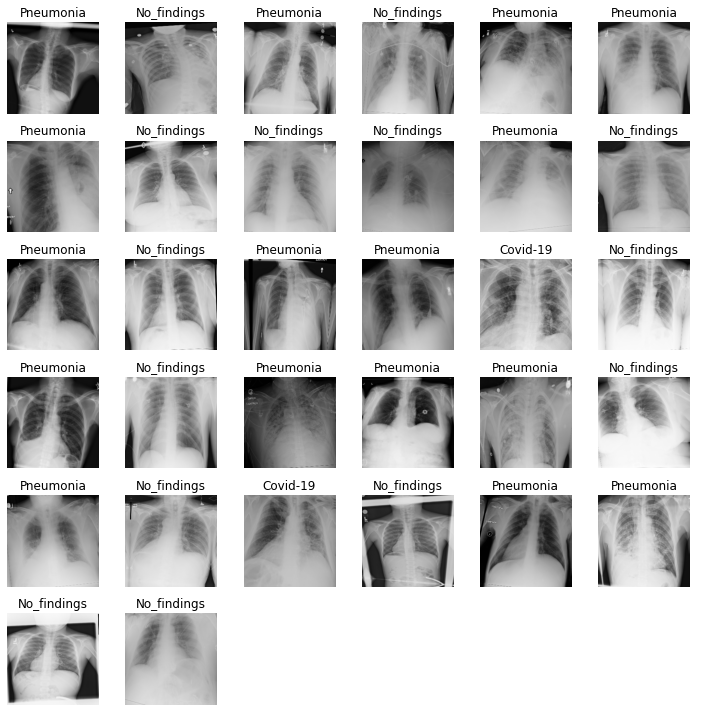

In [37]:
data.show_batch(rows=6, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [38]:
#ni as number of input and nf as number of filter

def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [39]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [40]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [41]:
#passing input size and filter size to the layers

model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    triple_conv(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [42]:
#  creating the learner(fastai library)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [43]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [44]:
# Fit the model using 1cycle policy with a cycle length of 50 using learning rate.
learn.fit_one_cycle(50, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.833138,1.134509,0.391111,02:40
1,0.723699,0.627048,0.737778,02:38
2,0.656621,0.511203,0.800000,02:40
3,0.625151,0.528748,0.777778,02:38
4,0.591796,0.631855,0.733333,02:42
5,0.584397,0.554993,0.804444,02:39
6,0.600368,0.592342,0.715556,02:38
7,0.589009,0.541303,0.791111,02:39
8,0.601531,0.414433,0.844444,02:39
9,0.609850,0.505120,0.773333,02:38


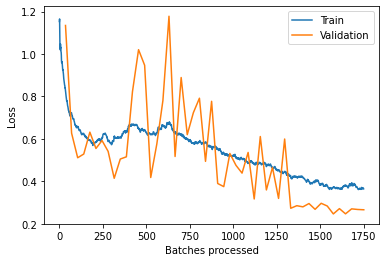

In [45]:
# Plot learning rate and momentum schedules.
learn.recorder.plot_losses()

In [46]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [47]:
# Predicting without TTA
# get the predictions and targets for the validation set.
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [48]:
accuracy(probs,targets)

tensor(0.8933)

In [49]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 1125, 225)

In [50]:
# probs as input channel, axis 1 is for row and 0 for col
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 201 0.8933333333333333
[[22  1  2]
 [ 0 94  6]
 [ 0 15 85]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.88      0.94        25
 No_findings       0.85      0.94      0.90       100
   Pneumonia       0.91      0.85      0.88       100

    accuracy                           0.89       225
   macro avg       0.92      0.89      0.90       225
weighted avg       0.90      0.89      0.89       225



In [51]:
# compare the actual labels with the labels predicted by the model.
interp = ClassificationInterpretation.from_learner(learn)

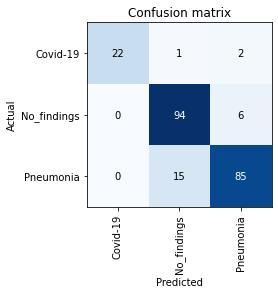

In [52]:
#confusion matrix
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);